# Backtesting the HMM Model - v3

Signals are identifed by the hmm model and imported into the system. 

    When signal = 1, we enter the mean reversion position.    
    When signal = 0, we enter the momentum position. 


Mean Reversion Strategy:
     
     1.We rank the returns of ETF stocks in the past month
     2.For bottom 3 stock, we buy     
     3.For top 3 stocks, we sell     
     4.We close the position every 10 days 


Momentum Strategy: 

     1.We rank the returns of ETF stocks in the past 10 months
     2.For bottom 3 stock, we buy     
     3.For top 3 stocks, we sell     
     4.We close the position every month 
    
    
    


In [7]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

# Import the backtrader platform
import backtrader as bt

import pandas as pd
from datetime import datetime

In [8]:

class RSI_Oversold(bt.Indicator):
    lines = ('oversold',)
    
    params = (
        ('level', 30),    
    )

    def __init__(self):
        self.lines.oversold = bt.indicators.RSI(self.data) < self.p.level

        
class DummyInd(bt.Indicator):
    lines = ('dummyline',)

    params = (('value', 5),)

    def __init__(self):
        self.lines.dummyline = bt.Max(0.0, self.params.value)

        
# Create a Stratey
class BackTradingStrategy(bt.Strategy):
    params = (
        ('period', 128),
        ("max_days_in_trade", 10)
    )

    def log(self, txt, txt2, txt3, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s, %s, %s' % (dt.isoformat(), txt, txt2, txt3))
        
        
    def read_signals(self):
        signal_data = pd.read_csv("hmm_regime_signals.csv")
        signal_data["datetime"] = signal_data["datetime"].apply(lambda x: datetime.strptime(x,"%m/%d/%Y"))
        signal_data = signal_data.set_index('datetime')
        
        return signal_data
        

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        # How to access individual etf
        self.xlb_close = self.datas[symbols.index("XLB")].close
        self.xle_close = self.datas[symbols.index("XLE")].close
        self.xlf_close = self.datas[symbols.index("XLF")].close
        self.xli_close = self.datas[symbols.index("XLI")].close
        self.xlk_close = self.datas[symbols.index("XLK")].close
        self.xlp_close = self.datas[symbols.index("XLP")].close
        self.xlu_close = self.datas[symbols.index("XLU")].close
        self.xlv_close = self.datas[symbols.index("XLV")].close
        self.xly_close = self.datas[symbols.index("XLY")].close
        
        self.datadate = self.datas[0].datetime.date
        self.days_in_trade = 0
        self.max_days_in_trade_mr = 10
        self.max_days_in_trade_mo = 21
        self.num_mr = 21
        self.num_mo = 21*10
        self.regime_state = 0
        self.mrr = 0.02
        self.mor = 0.05
        self.snum = 3
        self.signal_data = self.read_signals()
        # keep this 
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.period)        
        self.symbols = ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
        self.regimes = ['momentum', 'mean reversion']
        
        
    def stock_return(self, n):
        """calculate return in the past n days """        
        r_xlb = (self.xlb_close[0] - self.xlb_close[-n])/self.xlb_close[-n]
        r_xle = (self.xle_close[0] - self.xle_close[-n])/self.xle_close[-n]
        r_xlf = (self.xlf_close[0] - self.xlf_close[-n])/self.xlf_close[-n]
        r_xli = (self.xli_close[0] - self.xli_close[-n])/self.xli_close[-n]
        r_xlk = (self.xlk_close[0] - self.xlk_close[-n])/self.xlk_close[-n]
        r_xlp = (self.xlp_close[0] - self.xlp_close[-n])/self.xlp_close[-n]
        r_xlu = (self.xlu_close[0] - self.xlu_close[-n])/self.xlu_close[-n]
        r_xlv = (self.xlv_close[0] - self.xlv_close[-n])/self.xlv_close[-n]
        r_xly = (self.xly_close[0] - self.xly_close[-n])/self.xly_close[-n]
        r_list = [r_xlb, r_xle, r_xlf, r_xli, r_xlk, r_xlp, r_xlu, r_xlv, r_xly]        
        
        df = pd.DataFrame(r_list, index = self.symbols, columns = ['return'])
        
        return df
    
    
    
    def sort_return(self, n):
        """sort return in the past n days in ascending order 
           return the bottom and top 3 return stocks """
        
        df = self.stock_return(n)
        df = df.sort_values(by=['return'])
                
        stock_list = [df.index[0:3].tolist(),df.index[6:].tolist()]
        
        return stock_list
    
    
    
    def check_position(self):
        flag = False
        names = []
        for symbol in self.symbols:
            s_size = self.getposition(data=self.datas[symbols.index(symbol)]).size
            if  s_size != 0:
                flag = True
                names.append(symbol)
        return flag, names
            
                
    

    def next(self):
        # Simply log the closing price of the series from the reference               
        
        dt = self.datadate(0).strftime('%Y-%m-%d')
        
        signal = self.signal_data['state'].loc[dt]
        
        position, names = self.check_position()
        
        self.log('regime = %s' % self.regimes[signal], '      HAS Position at %s' % " ".join(names[:3]), ' and  at  %s' %  " ".join(names[3:]))

        
        
        # Check if we are in the market
        if not position:
            # if we do not have a position
            
            if signal == 1:
                """mean reversion"""
                
                stock_list = self.sort_return(self.num_mr)
                # print('stocklist = ', stock_list)
                
                self.log('regime = %s' % self.regimes[signal], 'CREATE BUY  for %s' % " ".join(stock_list[0]), ' SELL for %s' %  " ".join(stock_list[0])) 

                # Buy bottom snum stocks
                for i in range(self.snum):
                    self.order = self.buy(data = self.datas[symbols.index(stock_list[0][i])])
                    
                # Sell top snum stocks    
                for i in range(self.snum):
                    self.order = self.sell(data = self.datas[symbols.index(stock_list[1][i])])

                self.days_in_trade = 1
                
                self.regime_state = 1
                    
                    
         
            
            else:
                """momentum"""  
                
                stock_list = self.sort_return(self.num_mo)
                # print('stocklist = ', stock_list)
                
                self.log('regime = %s' % self.regimes[signal], '      CREATE SELL for %s' % " ".join(stock_list[0]), ' BUY  for %s' %  " ".join(stock_list[0]))

                # Sell bottom snum stocks
                for i in range(self.snum):
                    self.order = self.sell(data = self.datas[symbols.index(stock_list[0][i])])
                    
                # Buy top snum stocks    
                for i in range(self.snum):
                    self.order = self.buy(data = self.datas[symbols.index(stock_list[1][i])])
                    
                self.days_in_trade = 1
                
                self.regime_state = 0
                    
            
                
            

        else:
            # if we have a position
            
            self.days_in_trade += 1
            
            """mean reversion"""
            if (self.regime_state == 1):
            
                # close the position if regime shift or after holding it for max_mr days.
                if signal == 0 or self.days_in_trade == self.max_days_in_trade_mr:
                    num = len(names)
                    for i in range(num):
                        self.close(data=self.datas[symbols.index(names[i])])
                    
                    self.log('regime = %s' % self.regimes[signal], 'CLOSE Position  %s' % " ".join(names[:3]), ' and for  %s' %  " ".join(names[3:]))
                    self.days_in_trade = 0                    
                    self.regime_state = 0 
                    
            
            """momentum"""
            if (self.regime_state == 0):
                
                # close the position if regime shift or after holding it for max_mo days.
                if signal == 1 or self.days_in_trade == self.max_days_in_trade_mo:
                    num = len(names)
                    for i in range(num):
                        self.close(data=self.datas[symbols.index(names[i])])
                    
                    self.log('regime = %s' % self.regimes[signal], '      CLOSE Position  %s' % " ".join(names[:3]), ' and for  %s' %  " ".join(names[3:]))
                    self.days_in_trade = 0                        
                    self.regime_state = 1
                 
       


In [9]:


if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()   

    symbols = ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
    for symbol in symbols:
        datapath = os.path.join('../../../datas/%s.csv' % symbol)

        # Create a Data Feed
        data = bt.feeds.YahooFinanceCSVData(
            dataname=datapath,
            # Do not pass values before this date
            fromdate=datetime(2013, 2, 11),
            # Do not pass values before this date
            todate=datetime(2018, 2, 9),
            # Do not pass values after this date
            reverse=False)

        # Add the Data Feed to Cerebro
        cerebro.adddata(data, name=symbol)


    # Add a strategy
    cerebro.addstrategy(BackTradingStrategy) #, symbols= symbols)
    
    # Set our desired cash start
    cerebro.broker.setcash(100000.0)
    
    

    # Write output
    cerebro.addwriter(bt.WriterFile, out='0403-ETFbacktesting-v3.csv',csv=True)
    
    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
2013-08-13, regime = momentum,       HAS Position at ,  and  at  
2013-08-13, regime = momentum,       CREATE SELL for XLF XLK XLV,  BUY  for XLF XLK XLV
2013-08-14, regime = momentum,       HAS Position at XLB XLE XLF,  and  at  XLK XLP XLV
2013-08-15, regime = momentum,       HAS Position at XLB XLE XLF,  and  at  XLK XLP XLV
2013-08-16, regime = momentum,       HAS Position at XLB XLE XLF,  and  at  XLK XLP XLV
2013-08-19, regime = momentum,       HAS Position at XLB XLE XLF,  and  at  XLK XLP XLV
2013-08-20, regime = momentum,       HAS Position at XLB XLE XLF,  and  at  XLK XLP XLV
2013-08-21, regime = momentum,       HAS Position at XLB XLE XLF,  and  at  XLK XLP XLV
2013-08-22, regime = momentum,       HAS Position at XLB XLE XLF,  and  at  XLK XLP XLV
2013-08-23, regime = momentum,       HAS Position at XLB XLE XLF,  and  at  XLK XLP XLV
2013-08-26, regime = momentum,       HAS Position at XLB XLE XLF,  and  at  XLK XLP XLV
2013-08-27, regime

2014-01-10, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLU XLV XLY
2014-01-10, regime = momentum,       CLOSE Position  XLB XLE XLI,  and for  XLU XLV XLY
2014-01-13, regime = momentum,       HAS Position at ,  and  at  
2014-01-13, regime = momentum,       CREATE SELL for XLU XLE XLP,  BUY  for XLU XLE XLP
2014-01-14, regime = momentum,       HAS Position at XLE XLI XLP,  and  at  XLU XLV XLY
2014-01-15, regime = momentum,       HAS Position at XLE XLI XLP,  and  at  XLU XLV XLY
2014-01-16, regime = momentum,       HAS Position at XLE XLI XLP,  and  at  XLU XLV XLY
2014-01-17, regime = momentum,       HAS Position at XLE XLI XLP,  and  at  XLU XLV XLY
2014-01-21, regime = momentum,       HAS Position at XLE XLI XLP,  and  at  XLU XLV XLY
2014-01-22, regime = momentum,       HAS Position at XLE XLI XLP,  and  at  XLU XLV XLY
2014-01-23, regime = momentum,       HAS Position at XLE XLI XLP,  and  at  XLU XLV XLY
2014-01-24, regime = momentum,       HAS Position at X

2014-05-14, regime = momentum,       HAS Position at ,  and  at  
2014-05-14, regime = momentum,       CREATE SELL for XLY XLF XLP,  BUY  for XLY XLF XLP
2014-05-15, regime = momentum,       HAS Position at XLB XLF XLI,  and  at  XLP XLV XLY
2014-05-16, regime = momentum,       HAS Position at XLB XLF XLI,  and  at  XLP XLV XLY
2014-05-19, regime = momentum,       HAS Position at XLB XLF XLI,  and  at  XLP XLV XLY
2014-05-20, regime = momentum,       HAS Position at XLB XLF XLI,  and  at  XLP XLV XLY
2014-05-21, regime = momentum,       HAS Position at XLB XLF XLI,  and  at  XLP XLV XLY
2014-05-22, regime = momentum,       HAS Position at XLB XLF XLI,  and  at  XLP XLV XLY
2014-05-23, regime = momentum,       HAS Position at XLB XLF XLI,  and  at  XLP XLV XLY
2014-05-27, regime = momentum,       HAS Position at XLB XLF XLI,  and  at  XLP XLV XLY
2014-05-28, regime = momentum,       HAS Position at XLB XLF XLI,  and  at  XLP XLV XLY
2014-05-29, regime = momentum,       HAS Position at X

2014-09-22, regime = momentum,       HAS Position at XLB XLE XLK,  and  at  XLP XLV XLY
2014-09-23, regime = momentum,       HAS Position at XLB XLE XLK,  and  at  XLP XLV XLY
2014-09-24, regime = momentum,       HAS Position at XLB XLE XLK,  and  at  XLP XLV XLY
2014-09-25, regime = momentum,       HAS Position at XLB XLE XLK,  and  at  XLP XLV XLY
2014-09-26, regime = momentum,       HAS Position at XLB XLE XLK,  and  at  XLP XLV XLY
2014-09-29, regime = momentum,       HAS Position at XLB XLE XLK,  and  at  XLP XLV XLY
2014-09-30, regime = momentum,       HAS Position at XLB XLE XLK,  and  at  XLP XLV XLY
2014-10-01, regime = momentum,       HAS Position at XLB XLE XLK,  and  at  XLP XLV XLY
2014-10-02, regime = momentum,       HAS Position at XLB XLE XLK,  and  at  XLP XLV XLY
2014-10-03, regime = momentum,       HAS Position at XLB XLE XLK,  and  at  XLP XLV XLY
2014-10-06, regime = momentum,       HAS Position at XLB XLE XLK,  and  at  XLP XLV XLY
2014-10-07, regime = momentum,  

2015-02-11, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLK XLP XLV
2015-02-12, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLK XLP XLV
2015-02-13, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLK XLP XLV
2015-02-17, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLK XLP XLV
2015-02-18, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLK XLP XLV
2015-02-19, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLK XLP XLV
2015-02-20, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLK XLP XLV
2015-02-23, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLK XLP XLV
2015-02-24, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLK XLP XLV
2015-02-25, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLK XLP XLV
2015-02-26, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLK XLP XLV
2015-02-27, regime = momentum,  

2015-07-15, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLP XLV XLY
2015-07-16, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLP XLV XLY
2015-07-17, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLP XLV XLY
2015-07-20, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLP XLV XLY
2015-07-21, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLP XLV XLY
2015-07-22, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLP XLV XLY
2015-07-23, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLP XLV XLY
2015-07-24, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLP XLV XLY
2015-07-27, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLP XLV XLY
2015-07-28, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLP XLV XLY
2015-07-29, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLP XLV XLY
2015-07-30, regime = momentum,  

2015-11-17, regime = momentum,       HAS Position at XLB XLE XLF,  and  at  XLK XLU XLY
2015-11-18, regime = momentum,       HAS Position at XLB XLE XLF,  and  at  XLK XLU XLY
2015-11-19, regime = momentum,       HAS Position at XLB XLE XLF,  and  at  XLK XLU XLY
2015-11-20, regime = momentum,       HAS Position at XLB XLE XLF,  and  at  XLK XLU XLY
2015-11-23, regime = momentum,       HAS Position at XLB XLE XLF,  and  at  XLK XLU XLY
2015-11-24, regime = momentum,       HAS Position at XLB XLE XLF,  and  at  XLK XLU XLY
2015-11-25, regime = momentum,       HAS Position at XLB XLE XLF,  and  at  XLK XLU XLY
2015-11-27, regime = momentum,       HAS Position at XLB XLE XLF,  and  at  XLK XLU XLY
2015-11-30, regime = momentum,       HAS Position at XLB XLE XLF,  and  at  XLK XLU XLY
2015-12-01, regime = momentum,       HAS Position at XLB XLE XLF,  and  at  XLK XLU XLY
2015-12-02, regime = momentum,       HAS Position at XLB XLE XLF,  and  at  XLK XLU XLY
2015-12-03, regime = momentum,  

2016-03-28, regime = momentum,       HAS Position at XLB XLE XLP,  and  at  XLU XLV XLY
2016-03-29, regime = momentum,       HAS Position at XLB XLE XLP,  and  at  XLU XLV XLY
2016-03-30, regime = momentum,       HAS Position at XLB XLE XLP,  and  at  XLU XLV XLY
2016-03-31, regime = momentum,       HAS Position at XLB XLE XLP,  and  at  XLU XLV XLY
2016-04-01, regime = momentum,       HAS Position at XLB XLE XLP,  and  at  XLU XLV XLY
2016-04-04, regime = momentum,       HAS Position at XLB XLE XLP,  and  at  XLU XLV XLY
2016-04-05, regime = momentum,       HAS Position at XLB XLE XLP,  and  at  XLU XLV XLY
2016-04-06, regime = momentum,       HAS Position at XLB XLE XLP,  and  at  XLU XLV XLY
2016-04-07, regime = momentum,       HAS Position at XLB XLE XLP,  and  at  XLU XLV XLY
2016-04-08, regime = momentum,       HAS Position at XLB XLE XLP,  and  at  XLU XLV XLY
2016-04-11, regime = momentum,       HAS Position at XLB XLE XLP,  and  at  XLU XLV XLY
2016-04-12, regime = momentum,  

2016-08-18, regime = momentum,       HAS Position at XLB XLE XLF,  and  at  XLK XLU XLY
2016-08-19, regime = momentum,       HAS Position at XLB XLE XLF,  and  at  XLK XLU XLY
2016-08-22, regime = momentum,       HAS Position at XLB XLE XLF,  and  at  XLK XLU XLY
2016-08-23, regime = momentum,       HAS Position at XLB XLE XLF,  and  at  XLK XLU XLY
2016-08-24, regime = momentum,       HAS Position at XLB XLE XLF,  and  at  XLK XLU XLY
2016-08-25, regime = momentum,       HAS Position at XLB XLE XLF,  and  at  XLK XLU XLY
2016-08-26, regime = momentum,       HAS Position at XLB XLE XLF,  and  at  XLK XLU XLY
2016-08-29, regime = momentum,       HAS Position at XLB XLE XLF,  and  at  XLK XLU XLY
2016-08-29, regime = momentum,       CLOSE Position  XLB XLE XLF,  and for  XLK XLU XLY
2016-08-30, regime = momentum,       HAS Position at ,  and  at  
2016-08-30, regime = momentum,       CREATE SELL for XLY XLF XLV,  BUY  for XLY XLF XLV
2016-08-31, regime = momentum,       HAS Position at X

2017-01-03, regime = momentum,       HAS Position at XLE XLF XLI,  and  at  XLP XLU XLV
2017-01-04, regime = momentum,       HAS Position at XLE XLF XLI,  and  at  XLP XLU XLV
2017-01-04, regime = momentum,       CLOSE Position  XLE XLF XLI,  and for  XLP XLU XLV
2017-01-05, regime = momentum,       HAS Position at ,  and  at  
2017-01-05, regime = momentum,       CREATE SELL for XLP XLU XLV,  BUY  for XLP XLU XLV
2017-01-06, regime = momentum,       HAS Position at XLE XLF XLI,  and  at  XLP XLU XLV
2017-01-09, regime = momentum,       HAS Position at XLE XLF XLI,  and  at  XLP XLU XLV
2017-01-10, regime = momentum,       HAS Position at XLE XLF XLI,  and  at  XLP XLU XLV
2017-01-11, regime = momentum,       HAS Position at XLE XLF XLI,  and  at  XLP XLU XLV
2017-01-12, regime = momentum,       HAS Position at XLE XLF XLI,  and  at  XLP XLU XLV
2017-01-13, regime = momentum,       HAS Position at XLE XLF XLI,  and  at  XLP XLU XLV
2017-01-17, regime = mean reversion,       HAS Positio

2017-06-08, regime = mean reversion,       CLOSE Position  XLE XLF XLI,  and for  XLK XLP XLV
2017-06-09, regime = mean reversion,       HAS Position at ,  and  at  
2017-06-09, regime = mean reversion, CREATE BUY  for XLE XLY XLK,  SELL for XLE XLY XLK
2017-06-12, regime = momentum,       HAS Position at XLB XLE XLK,  and  at  XLP XLU XLY
2017-06-12, regime = momentum, CLOSE Position  XLB XLE XLK,  and for  XLP XLU XLY
2017-06-13, regime = momentum,       HAS Position at ,  and  at  
2017-06-13, regime = momentum,       CREATE SELL for XLE XLV XLP,  BUY  for XLE XLV XLP
2017-06-14, regime = momentum,       HAS Position at XLE XLF XLI,  and  at  XLK XLP XLV
2017-06-15, regime = momentum,       HAS Position at XLE XLF XLI,  and  at  XLK XLP XLV
2017-06-16, regime = momentum,       HAS Position at XLE XLF XLI,  and  at  XLK XLP XLV
2017-06-19, regime = momentum,       HAS Position at XLE XLF XLI,  and  at  XLK XLP XLV
2017-06-20, regime = momentum,       HAS Position at XLE XLF XLI,  and

2017-10-18, regime = momentum,       HAS Position at XLE XLK XLP,  and  at  XLU XLV XLY
2017-10-19, regime = momentum,       HAS Position at XLE XLK XLP,  and  at  XLU XLV XLY
2017-10-20, regime = momentum,       HAS Position at XLE XLK XLP,  and  at  XLU XLV XLY
2017-10-23, regime = momentum,       HAS Position at XLE XLK XLP,  and  at  XLU XLV XLY
2017-10-24, regime = momentum,       HAS Position at XLE XLK XLP,  and  at  XLU XLV XLY
2017-10-25, regime = momentum,       HAS Position at XLE XLK XLP,  and  at  XLU XLV XLY
2017-10-26, regime = momentum,       HAS Position at XLE XLK XLP,  and  at  XLU XLV XLY
2017-10-27, regime = mean reversion,       HAS Position at XLE XLK XLP,  and  at  XLU XLV XLY
2017-10-27, regime = mean reversion,       CLOSE Position  XLE XLK XLP,  and for  XLU XLV XLY
2017-10-30, regime = momentum,       HAS Position at ,  and  at  
2017-10-30, regime = momentum,       CREATE SELL for XLE XLP XLY,  BUY  for XLE XLP XLY
2017-10-31, regime = momentum,       HAS P

In [10]:
# calculate pnl using excel data
import pandas as pd
import matplotlib.pyplot as plt

dtime = pd.read_csv('datetime.csv')
data = pd.read_csv('0403-ETFbacktesting-v3.csv').fillna(value = 0)
data = data[:1260]

df = data[data.columns[-9:]].copy()
df.columns = symbols
df['datetime'] = dtime[['datetime']].copy()

n = len(df)
df['cumulative_pnl'] = df['XLB']

cpnl = 0.
count_plus = 0
count_minus = 0

for t in range(n):
    pnl = 0.
    for i in range(len(symbols)):
        profit = df[symbols[i]].iloc[t]
        # print('profit = ', profit)
        pnl = pnl + profit
        if (profit > 0.):
            count_plus +=1
        elif (profit < 0.):
            count_minus +=1
         
    cpnl = cpnl + pnl
    # print('cpnl = ', cpnl)
    df['cumulative_pnl'].iloc[t] = cpnl
    
print(df)

    

/home/project/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


       XLB   XLE   XLF   XLI   XLK   XLP   XLU   XLV   XLY    datetime  \
0     0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   2/11/2013   
1     0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   2/12/2013   
2     0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   2/13/2013   
3     0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   2/14/2013   
4     0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   2/15/2013   
5     0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   2/19/2013   
6     0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   2/20/2013   
7     0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   2/21/2013   
8     0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   2/22/2013   
9     0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   2/25/2013   
10    0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   2/26/2013   
11    0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   2/27/2013   
12    0.00  0.00  0.00  0.00  0.00  0.

In [11]:
plus_percent = 1.0*count_plus/(count_plus*1.0+count_minus*1.0) 
print('percentage of trading that make positive profits = ', plus_percent)

percentage of trading that make positive profits =  0.5222222222222223


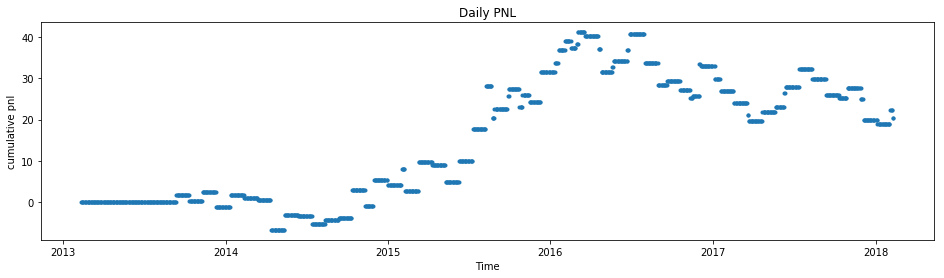

In [12]:
# convert string to datetime
df["datetime"] = df["datetime"].apply(lambda x: datetime.strptime(x,"%m/%d/%Y"))

# plot PNL figures 
plt.figure(figsize=(16, 4))
plt.plot(df['datetime'], df['cumulative_pnl'] ,'.') 
plt.xlabel("Time")
plt.ylabel("cumulative pnl")
plt.title("Daily PNL")
plt.show()